In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load and preprocess the dataset
def load_data(data_dir="/home/padhmawathy/traffic/traffic dataset new project/myData"):
    """
    Load images and labels from the dataset directory.
    The dataset should be organized as:
    dataset/
        0/
            *.png or *.jpg
        1/
            *.png or *.jpg
        ...
        42/
            *.png or *.jpg
    """
    images = []
    labels = []
    
    # Loop through each folder (class)
    for class_id in range(43):
        folder_path = os.path.join(data_dir, str(class_id))
        
        # Check if the folder exists
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found. Skipping...")
            continue
            
        # Get all image files in the folder
        files = os.listdir(folder_path)
        
        # Process each image
        for file in files:
            file_path = os.path.join(folder_path, file)
            
            # Read and resize image
            try:
                img = cv2.imread(file_path)
                img = cv2.resize(img, (30, 30))  # Resize to 30x30
                images.append(img)
                labels.append(class_id)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"Dataset loaded: {X.shape[0]} images with shape {X.shape[1:]}")
    
    return X, y

# 2. Split the data into training and testing sets
def prepare_data(X, y, test_size=0.2):
    """
    Split the data into training and testing sets (80:20 ratio).
    Normalize pixel values and flatten images for SVM.
    """
    # Flatten the images for SVM (convert 3D images to 1D vectors)
    n_samples = len(X)
    X_flattened = X.reshape(n_samples, -1)  # Reshape to (n_samples, n_features)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=test_size, random_state=42)
    
    # Normalize pixel values to [0, 1]
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    
    return X_train, X_test, y_train, y_test, X

# 3. Apply dimensionality reduction (optional but recommended for SVM with image data)
def apply_pca(X_train, X_test, n_components=100):
    """
    Apply PCA to reduce dimensionality of the data.
    """
    print(f"Applying PCA to reduce dimensions from {X_train.shape[1]} to {n_components}...")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Print explained variance
    explained_variance = sum(pca.explained_variance_ratio_) * 100
    print(f"Explained variance with {n_components} components: {explained_variance:.2f}%")
    
    return X_train_pca, X_test_pca, pca, scaler

# 4. Build SVM model
def create_svm_model(kernel='rbf', C=1.0, gamma='scale'):
    """
    Create an SVM model for traffic sign recognition.
    """
    model = SVC(
        kernel=kernel,  # 'rbf', 'linear', 'poly', 'sigmoid'
        C=C,            # Regularization parameter
        gamma=gamma,    # Kernel coefficient
        probability=True,
        random_state=42
    )
    
    print(f"SVM model created with kernel={kernel}, C={C}, gamma={gamma}")
    return model

# 5. Train the model
def train_model(model, X_train, y_train):
    """
    Train the SVM model.
    """
    # Start training time measurement
    start_time = time.time()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # End training time measurement
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return model, training_time

# 6. Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model using various metrics.
    """
    # Start prediction time measurement
    start_time = time.time()
    
    # Predict classes
    y_pred = model.predict(X_test)
    
    # End prediction time measurement
    prediction_time = time.time() - start_time
    print(f"Prediction completed in {prediction_time:.2f} seconds")
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Calculate class-wise metrics
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'class_report': class_report,
        'confusion_matrix': conf_matrix,
        'y_pred': y_pred,
        'prediction_time': prediction_time
    }

# 7. Visualize evaluation metrics
def plot_evaluation_metrics(metrics):
    """
    Visualize evaluation metrics using bar plots.
    """
    # Bar plot for accuracy, precision, recall, f1-score
    plt.figure(figsize=(10, 6))
    metrics_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    sns.barplot(x=metrics_names, y=metrics_values)
    plt.title('SVM Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Add value labels on top of bars
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('svm_evaluation_metrics.png')
    plt.show()

# 8. Visualize confusion matrix
def plot_confusion_matrix(conf_matrix):
    """
    Plot the confusion matrix as a heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=False, cmap='Blues', fmt='d', cbar=True)
    plt.title('SVM Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('svm_confusion_matrix.png')
    plt.show()

# 9. Display sample predictions
def display_sample_predictions(X_original, X_test, y_test, y_pred, pca, scaler, num_samples=5):
    """
    Display sample images with their true and predicted labels.
    """
    # Get random indices
    indices = np.random.choice(len(y_test), num_samples, replace=False)
    
    # Get original images (reshape back to image format)
    image_shape = X_original.shape[1:]  # Shape of original images
    
    # Create a figure
    plt.figure(figsize=(15, 3))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        
        # Get the original image index from the test set
        original_idx = y_test.index[idx] if hasattr(y_test, 'index') else idx
        
        # Display the image
        plt.imshow(X_original[original_idx])
        plt.title(f"True: {y_test[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('svm_sample_predictions.png')
    plt.show()

# 10. Plot PCA explained variance
def plot_pca_variance(pca):
    """
    Plot the explained variance ratio of PCA components.
    """
    plt.figure(figsize=(10, 6))
    
    # Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Plot
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pca_explained_variance.png')
    plt.show()

# Main execution
def main():
    try:
        # 1. Load data
        print("Loading dataset...")
        X, y = load_data()
        
        # 2. Prepare data
        print("\nPreparing data...")
        X_train, X_test, y_train, y_test, X_original = prepare_data(X, y)
        
        # 3. Apply PCA (reduce dimensions for SVM)
        X_train_pca, X_test_pca, pca, scaler = apply_pca(X_train, X_test, n_components=100)
        
        # 4. Create model
        print("\nCreating SVM model...")
        svm_model = create_svm_model(kernel='rbf', C=10.0, gamma='scale')
        
        # 5. Train model
        print("\nTraining model...")
        svm_model, training_time = train_model(svm_model, X_train_pca, y_train)
        
        # 6. Evaluate model
        print("\nEvaluating model...")
        metrics = evaluate_model(svm_model, X_test_pca, y_test)
        
        # 7. Visualize results
        print("\nVisualizing results...")
        plot_evaluation_metrics(metrics)
        plot_confusion_matrix(metrics['confusion_matrix'])
        # Note: For SVM with PCA, sample prediction visualization is more complex
        # plot_pca_variance(pca)
        
        # Save model (using joblib as pickle may have issues with large SVM models)
        import joblib
        joblib.dump(svm_model, 'traffic_sign_svm_model.pkl')
        joblib.dump(pca, 'traffic_sign_pca.pkl')
        joblib.dump(scaler, 'traffic_sign_scaler.pkl')
        print("Models saved as 'traffic_sign_svm_model.pkl', 'traffic_sign_pca.pkl', and 'traffic_sign_scaler.pkl'")
        
        # Print overall summary
        print("\n=== Traffic Sign Recognition System (SVM) Summary ===")
        print(f"Total samples: {len(X)}")
        print(f"Training samples: {len(X_train)}")
        print(f"Testing samples: {len(X_test)}")
        print(f"Original features: {X_train.shape[1]}")
        print(f"PCA features: {X_train_pca.shape[1]}")
        print(f"Number of classes: 43")
        print(f"Training time: {training_time:.2f} seconds")
        print(f"Prediction time: {metrics['prediction_time']:.2f} seconds")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")
        
    except Exception as e:
        print(f"Error in execution: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Loading dataset...
Dataset loaded: 73139 images with shape (30, 30, 3)

Preparing data...


Loading dataset...
Dataset loaded: 73139 images with shape (30, 30, 3)

Preparing data...
Training set: 58511 samples, 2700 features
Testing set: 14628 samples, 2700 features
Applying PCA to reduce dimensions from 2700 to 100...
Explained variance with 100 components: 96.48%

Creating SVM model...
SVM model created with kernel=rbf, C=10.0, gamma=scale

Training model with early stopping at 96% accuracy...
Starting incremental training with early stopping at 0.96 accuracy...
Training with 5851 samples (10.0% of training data)...
Training with 10.0% data - Accuracy: 0.8253, Time: 22.48s
Training with 11702 samples (20.0% of training data)...
Training with 20.0% data - Accuracy: 0.8990, Time: 53.45s
Training with 17553 samples (30.0% of training data)...
Training with 30.0% data - Accuracy: 0.9277, Time: 103.32s
Training with 23404 samples (40.0% of training data)...
Training with 40.0% data - Accuracy: 0.9431, Time: 167.54s
Training with 29255 samples (50.0% of training data)...
Training

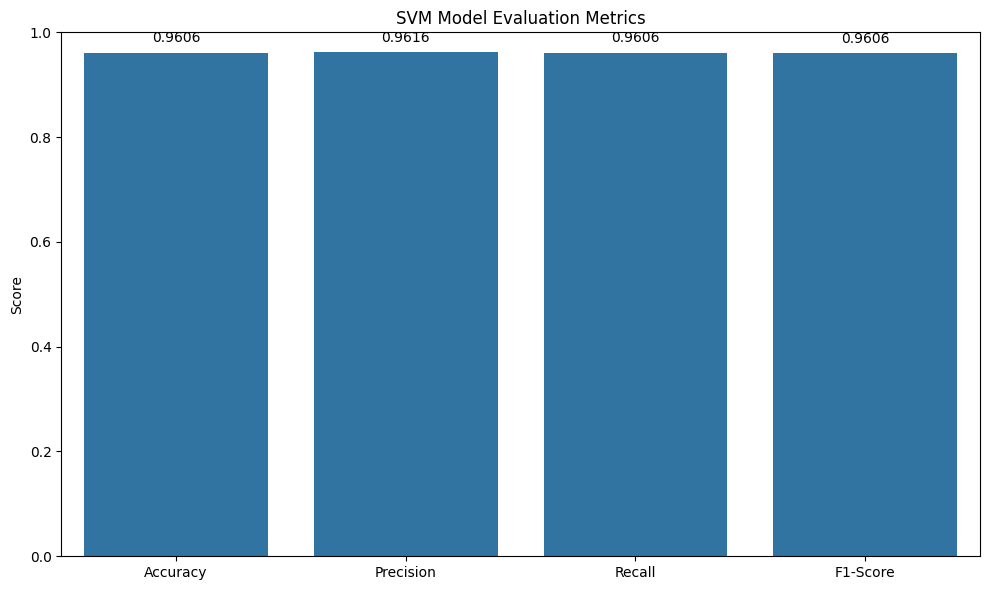

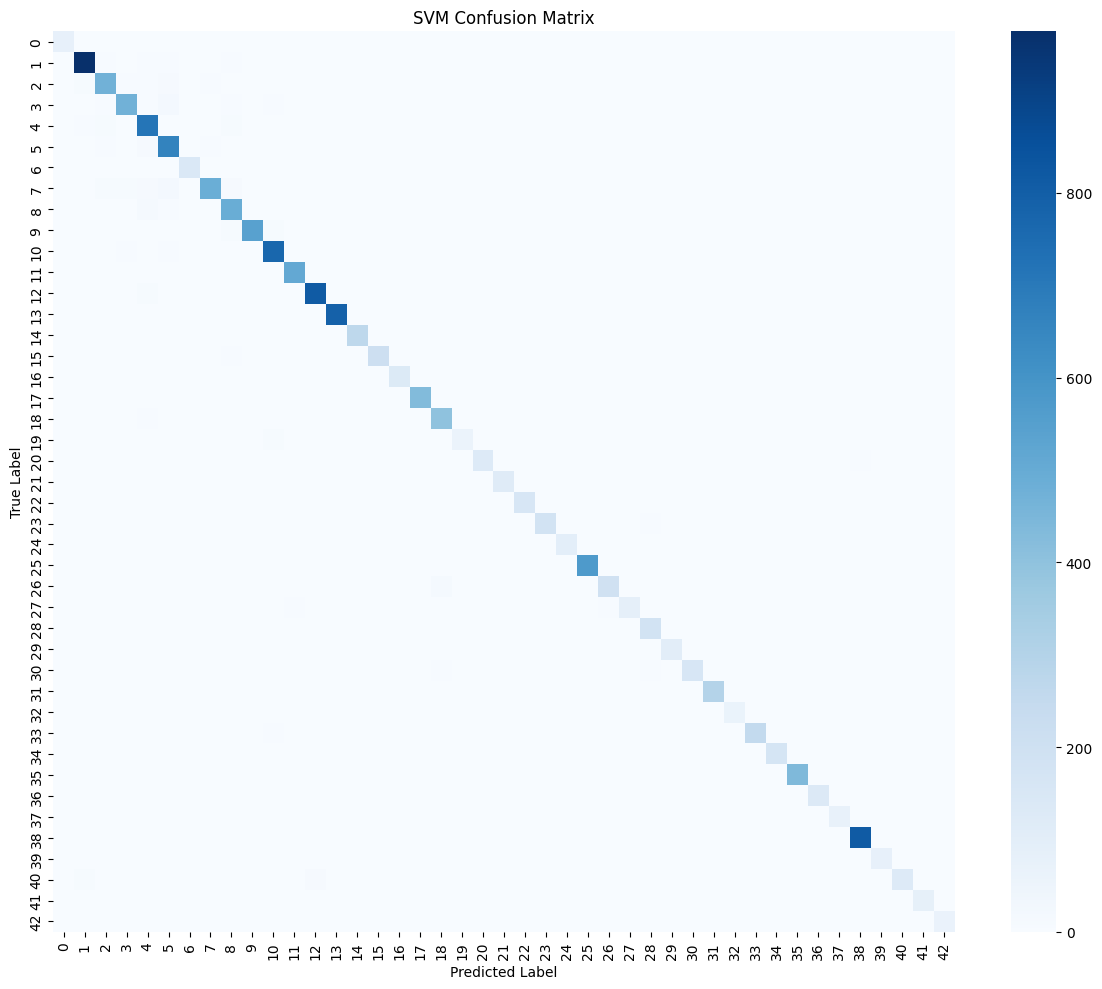

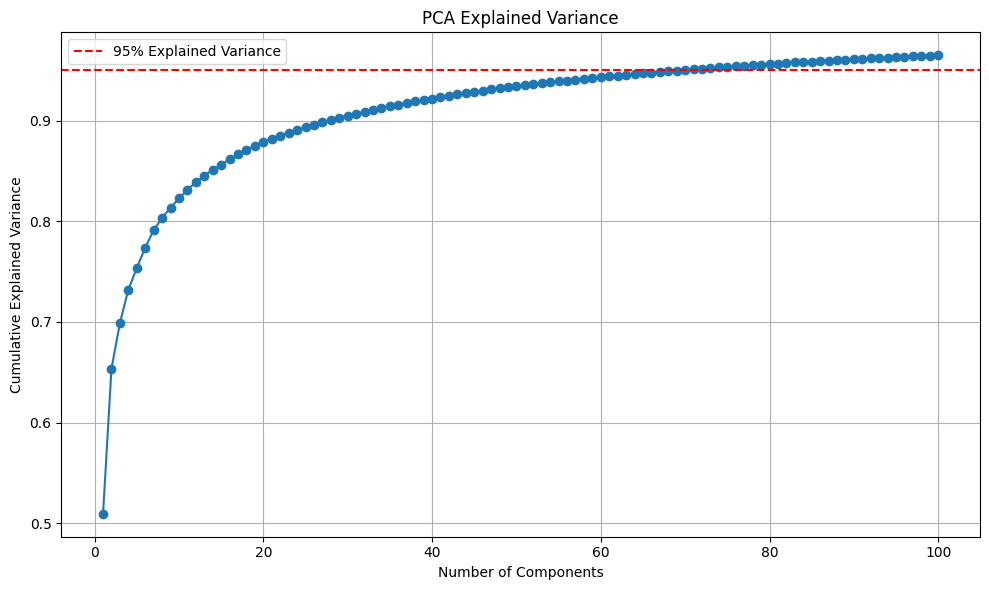

Models saved as 'traffic_sign_svm_model.pkl', 'traffic_sign_pca.pkl', and 'traffic_sign_scaler.pkl'

=== Traffic Sign Recognition System (SVM) Summary ===
Total samples: 73139
Training samples: 58511
Testing samples: 14628
Original features: 2700
PCA features: 100
Number of classes: 43
Training time: 1008.05 seconds
Prediction time: 54.66 seconds
Accuracy: 0.9606
Target accuracy reached: Yes
Precision: 0.9616
Recall: 0.9606
F1-Score: 0.9606


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time

# Set random seed for reproducibility
np.random.seed(42)

# 1. Load and preprocess the dataset
def load_data(data_dir="/home/padhmawathy/traffic/traffic dataset new project/myData"):
    """
    Load images and labels from the dataset directory.
    The dataset should be organized as:
    dataset/
        0/
            *.png or *.jpg
        1/
            *.png or *.jpg
        ...
        42/
            *.png or *.jpg
    """
    images = []
    labels = []
    
    # Loop through each folder (class)
    for class_id in range(43):
        folder_path = os.path.join(data_dir, str(class_id))
        
        # Check if the folder exists
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found. Skipping...")
            continue
            
        # Get all image files in the folder
        files = os.listdir(folder_path)
        
        # Process each image
        for file in files:
            file_path = os.path.join(folder_path, file)
            
            # Read and resize image
            try:
                img = cv2.imread(file_path)
                img = cv2.resize(img, (30, 30))  # Resize to 30x30
                images.append(img)
                labels.append(class_id)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    # Convert to numpy arrays
    X = np.array(images)
    y = np.array(labels)
    
    print(f"Dataset loaded: {X.shape[0]} images with shape {X.shape[1:]}")
    
    return X, y

# 2. Split the data into training and testing sets
def prepare_data(X, y, test_size=0.2):
    """
    Split the data into training and testing sets (80:20 ratio).
    Normalize pixel values and flatten images for SVM.
    """
    # Flatten the images for SVM (convert 3D images to 1D vectors)
    n_samples = len(X)
    X_flattened = X.reshape(n_samples, -1)  # Reshape to (n_samples, n_features)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=test_size, random_state=42)
    
    # Normalize pixel values to [0, 1]
    X_train = X_train / 255.0
    X_test = X_test / 255.0
    
    print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Testing set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
    
    return X_train, X_test, y_train, y_test, X

# 3. Apply dimensionality reduction (optional but recommended for SVM with image data)
def apply_pca(X_train, X_test, n_components=100):
    """
    Apply PCA to reduce dimensionality of the data.
    """
    print(f"Applying PCA to reduce dimensions from {X_train.shape[1]} to {n_components}...")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Print explained variance
    explained_variance = sum(pca.explained_variance_ratio_) * 100
    print(f"Explained variance with {n_components} components: {explained_variance:.2f}%")
    
    return X_train_pca, X_test_pca, pca, scaler

# 4. Build SVM model
def create_svm_model(kernel='rbf', C=1.0, gamma='scale'):
    """
    Create an SVM model for traffic sign recognition.
    """
    model = SVC(
        kernel=kernel,  # 'rbf', 'linear', 'poly', 'sigmoid'
        C=C,            # Regularization parameter
        gamma=gamma,    # Kernel coefficient
        probability=True,
        random_state=42
    )
    
    print(f"SVM model created with kernel={kernel}, C={C}, gamma={gamma}")
    return model

# 5. Train the model
def train_model(model, X_train, y_train, X_val=None, y_val=None, target_accuracy=0.96):
    """
    Train the SVM model with early stopping when reaching target accuracy.
    
    Parameters:
    - model: The SVM model to train
    - X_train: Training features
    - y_train: Training labels
    - X_val: Validation features (for accuracy checking)
    - y_val: Validation labels (for accuracy checking)
    - target_accuracy: Stop training when this accuracy is reached
    """
    # Start training time measurement
    start_time = time.time()
    
    # If no validation set is provided, use a portion of training set
    if X_val is None or y_val is None:
        print("No validation set provided. Using 20% of training data for validation...")
        X_train_sub, X_val, y_train_sub, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42
        )
    else:
        X_train_sub = X_train
        y_train_sub = y_train
    
    # For SVM, we can't do true early stopping during training (as it's not an iterative algorithm)
    # Instead, we'll try different training set sizes until we reach target accuracy
    
    # Define possible training set sizes (percentages)
    train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    current_accuracy = 0.0
    final_model = None
    partial_training_time = 0
    
    print(f"Starting incremental training with early stopping at {target_accuracy} accuracy...")
    
    for size in train_sizes:
        # Skip if we've already reached target accuracy
        if current_accuracy >= target_accuracy:
            print(f"Target accuracy of {target_accuracy} already reached. Stopping training.")
            break
        
        # Calculate number of samples to use
        n_samples = int(len(X_train_sub) * size)
        print(f"Training with {n_samples} samples ({size*100:.1f}% of training data)...")
        
        # Get subset of training data
        X_subset = X_train_sub[:n_samples]
        y_subset = y_train_sub[:n_samples]
        
        # Train model on subset
        subset_start_time = time.time()
        model.fit(X_subset, y_subset)
        subset_training_time = time.time() - subset_start_time
        partial_training_time += subset_training_time
        
        # Evaluate on validation set
        y_pred = model.predict(X_val)
        current_accuracy = accuracy_score(y_val, y_pred)
        
        print(f"Training with {size*100:.1f}% data - Accuracy: {current_accuracy:.4f}, Time: {subset_training_time:.2f}s")
        
        # Save current model state
        final_model = model
        
        # Early stopping check
        if current_accuracy >= target_accuracy:
            print(f"Reached target accuracy of {target_accuracy}! Stopping training.")
            break
    
    # If we've gone through all sizes and still haven't reached target accuracy,
    # train on full dataset as a last resort (if we haven't already)
    if current_accuracy < target_accuracy and size < 1.0:
        print(f"Target accuracy not reached with partial training. Training on full dataset...")
        full_start_time = time.time()
        model.fit(X_train, y_train)
        full_training_time = time.time() - full_start_time
        partial_training_time += full_training_time
        
        # Final evaluation
        y_pred = model.predict(X_val)
        current_accuracy = accuracy_score(y_val, y_pred)
        print(f"Final accuracy with full training data: {current_accuracy:.4f}")
        final_model = model
    
    # End training time measurement
    training_time = time.time() - start_time
    print(f"Total training process completed in {training_time:.2f} seconds")
    print(f"Actual model training time: {partial_training_time:.2f} seconds")
    
    return final_model, training_time

# 6. Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model using various metrics.
    """
    # Start prediction time measurement
    start_time = time.time()
    
    # Predict classes
    y_pred = model.predict(X_test)
    
    # End prediction time measurement
    prediction_time = time.time() - start_time
    print(f"Prediction completed in {prediction_time:.2f} seconds")
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Calculate class-wise metrics
    class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'class_report': class_report,
        'confusion_matrix': conf_matrix,
        'y_pred': y_pred,
        'prediction_time': prediction_time
    }

# 7. Visualize evaluation metrics
def plot_evaluation_metrics(metrics):
    """
    Visualize evaluation metrics using bar plots.
    """
    # Bar plot for accuracy, precision, recall, f1-score
    plt.figure(figsize=(10, 6))
    metrics_values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    sns.barplot(x=metrics_names, y=metrics_values)
    plt.title('SVM Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    
    # Add value labels on top of bars
    for i, v in enumerate(metrics_values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center')
    
    plt.tight_layout()
    plt.savefig('svm_evaluation_metrics.png')
    plt.show()

# 8. Visualize confusion matrix
def plot_confusion_matrix(conf_matrix):
    """
    Plot the confusion matrix as a heatmap.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=False, cmap='Blues', fmt='d', cbar=True)
    plt.title('SVM Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('svm_confusion_matrix.png')
    plt.show()

# 9. Display sample predictions
def display_sample_predictions(X_original, X_test, y_test, y_pred, pca, scaler, num_samples=5):
    """
    Display sample images with their true and predicted labels.
    """
    # Get random indices
    indices = np.random.choice(len(y_test), num_samples, replace=False)
    
    # Get original images (reshape back to image format)
    image_shape = X_original.shape[1:]  # Shape of original images
    
    # Create a figure
    plt.figure(figsize=(15, 3))
    
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i+1)
        
        # Get the original image index from the test set
        original_idx = y_test.index[idx] if hasattr(y_test, 'index') else idx
        
        # Display the image
        plt.imshow(X_original[original_idx])
        plt.title(f"True: {y_test[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('svm_sample_predictions.png')
    plt.show()

# 10. Plot PCA explained variance
def plot_pca_variance(pca):
    """
    Plot the explained variance ratio of PCA components.
    """
    plt.figure(figsize=(10, 6))
    
    # Cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    
    # Plot
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.grid(True)
    plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('pca_explained_variance.png')
    plt.show()

# Main execution
def main():
    try:
        # 1. Load data
        print("Loading dataset...")
        X, y = load_data()
        
        # 2. Prepare data
        print("\nPreparing data...")
        X_train, X_test, y_train, y_test, X_original = prepare_data(X, y)
        
        # 3. Apply PCA (reduce dimensions for SVM)
        X_train_pca, X_test_pca, pca, scaler = apply_pca(X_train, X_test, n_components=100)
        
        # 4. Create model
        print("\nCreating SVM model...")
        svm_model = create_svm_model(kernel='rbf', C=10.0, gamma='scale')
        
        # 5. Train model with early stopping
        print("\nTraining model with early stopping at 96% accuracy...")
        svm_model, training_time = train_model(svm_model, X_train_pca, y_train, X_test_pca, y_test, target_accuracy=0.96)
        
        # 6. Evaluate model
        print("\nEvaluating model...")
        metrics = evaluate_model(svm_model, X_test_pca, y_test)
        
        # 7. Visualize results
        print("\nVisualizing results...")
        plot_evaluation_metrics(metrics)
        plot_confusion_matrix(metrics['confusion_matrix'])
        plot_pca_variance(pca)
        
        # Save model (using joblib as pickle may have issues with large SVM models)
        import joblib
        joblib.dump(svm_model, 'traffic_sign_svm_model.pkl')
        joblib.dump(pca, 'traffic_sign_pca.pkl')
        joblib.dump(scaler, 'traffic_sign_scaler.pkl')
        print("Models saved as 'traffic_sign_svm_model.pkl', 'traffic_sign_pca.pkl', and 'traffic_sign_scaler.pkl'")
        
        # Print overall summary
        print("\n=== Traffic Sign Recognition System (SVM) Summary ===")
        print(f"Total samples: {len(X)}")
        print(f"Training samples: {len(X_train)}")
        print(f"Testing samples: {len(X_test)}")
        print(f"Original features: {X_train.shape[1]}")
        print(f"PCA features: {X_train_pca.shape[1]}")
        print(f"Number of classes: 43")
        print(f"Training time: {training_time:.2f} seconds")
        print(f"Prediction time: {metrics['prediction_time']:.2f} seconds")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Target accuracy reached: {'Yes' if metrics['accuracy'] >= 0.96 else 'No'}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1-Score: {metrics['f1_score']:.4f}")
        
    except Exception as e:
        print(f"Error in execution: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()